In [1]:
%load_ext lab_black
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
import glob
import tqdm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL


import umap
import lightgbm as lgb

from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.impute import KNNImputer, SimpleImputer

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, f_regression, SelectFromModel

In [2]:
def gather_df(
    dataset_name,
    detrend_features=True,
    shift_features=True,
    shift_features_longterm=True,
):
    fname = "./data/kaggle-preprocessed/{}.feather".format(dataset_name)
    if not os.path.exists(fname):
        raise Exception("preprocessed file doesnt exist")
    df = pd.read_feather(fname)
    df = df.set_index(df.index_col)
    df = df.drop("index_col", axis=1).drop("Date", axis=1)
    related_datas = []
    for col in df.columns:
        if "rain" in col:
            location = col.replace("rainfall_", "")
        elif "temperature" in col:
            location = col.replace("temperature_", "")
        else:
            continue
        filename = "./data/nasa-power/{}.feather".format(location)
        if os.path.exists(filename):
            df_related = pd.read_feather(filename)
            df_related = df_related.set_index(df_related.index_col)
            df_related = df_related.drop("index_col", axis=1)
            df_related.columns = [
                "{}_{}".format(location, c.lower()) for c in df_related.columns
            ]

            related_datas.append(df_related)
        else:
            print("not found: {}".format(col))

    df_related = pd.concat(related_datas)
    df_related = df_related.groupby(df_related.index).max()
    df = pd.merge(df, df_related, how="left", left_index=True, right_index=True)
    for col in df.columns:
        if "_index" in col:
            df = df.drop(col, axis=1)
    for col in df.columns:
        df[col] = df[col].astype(np.float)

    ignore_cols = ["year", "month", "week", "day", " day_of_year"]

    df = df.rename(
        columns={
            "flow_rate_lupa": "target_flow_rate_lupa",
            "depth_to_groundwater_cos": "target_depth_to_groundwater_cos",
            "depth_to_groundwater_pozzo_9": "target_depth_to_groundwater_pozzo_9",
            "flow_rate_madonna_di_canneto": "target_flow_rate_madonna_di_canneto",
        }
    )

    if dataset_name == "aquifer_luco":
        df = df.rename(
            columns={
                "target_depth_to_groundwater_pozzo_1": "depth_to_groundwater_pozzo_1",
                "target_depth_to_groundwater_pozzo_3": "depth_to_groundwater_pozzo_3",
                "target_depth_to_groundwater_pozzo_4": "depth_to_groundwater_pozzo_4",
            }
        )

    if detrend_features:
        for col in tqdm.tqdm(df.columns):

            if df[col].dtype != np.float64 or col in ignore_cols:
                continue
            decomp = seasonal_decompose(
                df[col].ffill().fillna(0),
                freq=52,
                model="additive",
                extrapolate_trend="freq",
            )
            df[f"{col}_trend"] = decomp.trend
            df[f"{col}_resid"] = decomp.resid
            df[f"{col}_seasonal"] = decomp.seasonal
    if shift_features:
        for col in df.columns:
            if "shift" not in col:
                for i in range(1, 5):
                    df["{}_shift_{}".format(col, i)] = df[col].shift(i)
                for i in range(5, 20, 5):
                    df["{}_shift_{}".format(col, i)] = (
                        df[col].rolling(5).mean().shift(i)
                    )
    if shift_features_longterm:
        for col in tqdm.tqdm(df.columns):
            if "shift" not in col and df[col].dtype == np.float or col in ignore_cols:
                for i in range(1, 12):
                    df["{}_shift_longterm_{}".format(col, i)] = (
                        df[col].rolling(30).mean().shift(i * 30)
                    )

    return df


def get_target_df(target):
    # detrend the target signal into trend/season/resid as well

    stl = STL(target.ffill().fillna(0), seasonal=13)
    res = stl.fit()
    df = pd.DataFrame(
        {
            "season": res.seasonal,
            "trend": res.trend,
            "resid": res.resid,
            "target": target,
        }
    )
    return df

In [ ]:
results = []
data_sets = [
    "aquifer_auser",
    "water_spring_amiata",
    "aquifer_petrignano",
    "aquifer_doganella",
    "aquifer_luco",
    "river_arno",
    "lake_bilancino",
    "water_spring_lupa",
    "water_spring_madonna_di_canneto",
]
for dataset in data_sets:
    df = gather_df(dataset, False, False, False)

    for target_col in [c for c in df.columns if "target" in c]:
        for shift in [30, 60]:
            y = get_target_df(df[target_col].shift(-shift).replace(0, np.nan)).target

            pipeline = Pipeline(
                memory=None,
                steps=[
                    ("impute", KNNImputer()),
                    (
                        "scaling",
                        StandardScaler(copy=True, with_mean=True, with_std=True),
                    ),
                    ("best", SelectFromModel(lgb.LGBMRegressor())),
                    #                     ("dim_reduction", PCA(n_components=50)),
                    #                             ("dim_reduction", umap.UMAP(n_components=5)),
                ],
                verbose=False,
            )

            for split in range(800, len(df.index), 100):

                X_train = df.iloc[: split - shift]
                X_test = df.iloc[split:]
                y_train = y.iloc[: split - shift]
                y_test = y.iloc[split:]

                x_filtered = ~pd.isna(y_train)

                if len(X_train[x_filtered]) < 500:
                    continue

                X_train_piped = pipeline.fit_transform(
                    X_train[x_filtered], y_train[x_filtered]
                )
                X_test_piped = pipeline.transform(X_test)
                y_train = y_train[x_filtered]

                from network import *

                p = dict(
                    seq_len=60,
                    batch_size=40,
                    criterion=nn.MSELoss(),
                    max_epochs=50,
                    n_features=X_train_piped.shape[1],
                    hidden_size=128,
                    num_layers=2,
                    dropout=0.5,
                    learning_rate=0.0002,
                )

                model = LSTMRegressor(
                    n_features=p["n_features"],
                    hidden_size=p["hidden_size"],
                    seq_len=p["seq_len"],
                    batch_size=p["batch_size"],
                    criterion=p["criterion"],
                    num_layers=p["num_layers"],
                    dropout=p["dropout"],
                    learning_rate=p["learning_rate"],
                )

                seed_everything(1)

                csv_logger = (CSVLogger("./", name="lstm", version="0"),)

                trainer = Trainer(max_epochs=p["max_epochs"],  gpus=1)

                target_scaler = RobustScaler()

                dm = MyDataModule(
                    X_train=X_train_piped,
                    y_train=target_scaler.fit_transform(y_train.values.reshape(-1, 1)),
                    X_test=X_test_piped,
                    y_test=target_scaler.transform(
                        y_test.ffill().bfill().values.reshape(-1, 1)
                    ),
                    seq_len=p["seq_len"],
                    batch_size=p["batch_size"],
                )
                trainer.fit(model, dm)
                ps = []
                ps_range = []
                ps_mean = []
                ps_max = []

                feats = []
                ys = []
                for x in dm.test_dataloader():
                    preds = [model(x[0]).detach().numpy()[:, 0] for i in range(30)]
                    [ps.append(p) for p in model(x[0]).detach().numpy()]
                    [ps_range.append(p) for p in [np.std(preds, axis=0)][0]]
                    [ps_mean.append(p) for p in [np.mean(preds, axis=0)][0]]
                    [ps_max.append(p) for p in [np.max(preds, axis=0)][0]]

                    [feats.append(p) for p in model.forward_no_lastlayer(x[0]).detach().numpy()]
                    [ys.append(y[0]) for y in x[1].detach().numpy()]
                    if len(ys) > 100:
                        break
                dfp = pd.DataFrame(
                    {
                        "p": np.array(ps)[:, 0],
                        "y": ys,
                        "prange": ps_range,
                        "pmean": ps_mean,
                        "pmax": ps_max,
                    }
                )
                dfp = pd.DataFrame(target_scaler.inverse_transform(dfp))
                dfp.columns = ["p", "y", "prange", "pmean", "pmax"]
                dfp.prange = ps_range
                dfp = dfp.iloc[:100]
                mae = np.mean(np.abs(dfp.p - dfp.y))
                rmse= np.sqrt(np.mean(dfp.p - dfp.y)**2)
                results.append({
                    'dataset': dataset,
                    'split': split,
                    'mae': mae,
                    'rmse': rmse,
                    'type': 'lstm',
                     'target_col': target_col,
                    'shift': shift
                })
                pd.DataFrame(results).to_json('./simres-lstm.json')

In [64]:

# dfp.y = y_test.values[59:]
# dfp = dfp.iloc[:100]
# np.mean(np.abs(dfp.p - dfp.y))

In [65]:
dfp = dfp.iloc[:100]
np.mean(np.abs(dfp.p - dfp.y))

0.16765514689683933

In [57]:
np.mean(np.abs(dfp.pmean - dfp.y))

0.14700443661212878

In [58]:
pd.DataFrame(feats).corr()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.000000,-0.845012,0.827044,0.822170,0.680278,-0.748992,-0.589081,-0.775016,-0.756957,-0.520598,-0.748310,0.773875,0.770765,-0.141948,0.847626
1,-0.845012,1.000000,-0.817866,-0.921006,-0.916187,0.944245,0.720466,0.775079,0.934712,0.749261,0.870103,-0.903170,-0.957612,-0.008710,-0.933964
2,0.827044,-0.817866,1.000000,0.818205,0.674942,-0.705496,-0.625324,-0.714087,-0.726607,-0.607207,-0.707748,0.756865,0.753617,0.120806,0.832930
3,0.822170,-0.921006,0.818205,1.000000,0.804561,-0.861298,-0.636522,-0.768735,-0.881380,-0.790136,-0.819707,0.881927,0.907423,0.058809,0.935951
4,0.680278,-0.916187,0.674942,0.804561,1.000000,-0.921572,-0.742358,-0.672535,-0.846979,-0.775402,-0.804735,0.851331,0.956616,0.101196,0.853945
5,-0.748992,0.944245,-0.705496,-0.861298,-0.921572,1.000000,0.646848,0.724172,0.931100,0.722173,0.881991,-0.872186,-0.920669,0.079070,-0.854410
6,-0.589081,0.720466,-0.625324,-0.636522,-0.742358,0.646848,1.000000,0.377672,0.657970,0.522427,0.467259,-0.568759,-0.746271,-0.350476,-0.685710
7,-0.775016,0.775079,-0.714087,-0.768735,-0.672535,0.724172,0.377672,1.000000,0.664614,0.670674,0.759068,-0.809572,-0.739497,0.194915,-0.819144
8,-0.756957,0.934712,-0.726607,-0.881380,-0.846979,0.931100,0.657970,0.664614,1.000000,0.672108,0.855402,-0.853038,-0.883776,-0.011908,-0.848986
9,-0.520598,0.749261,-0.607207,-0.790136,-0.775402,0.722173,0.522427,0.670674,0.672108,1.000000,0.699886,-0.851927,-0.853248,-0.253035,-0.850738


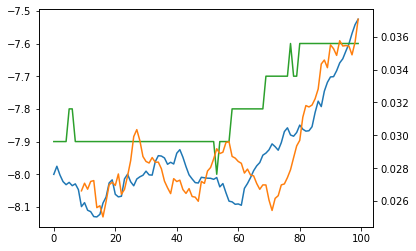

In [59]:
dfp.pmean.plot()
# dfp.pmax.plot()
dfp.prange.rolling(10).mean().plot(secondary_y=True)
dfp.y.plot()